In [156]:
# # Magic line to force reload all modules when this cell is run multiple times
# %load_ext autoreload
# %autoreload 2

import sys, os
sys.path.insert(0, os.path.expanduser("~/Developer/interpretDL/Pipeline"))

In [157]:
import plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot
from plotly.offline import plot
import ipywidgets as widgets

# %matplotlib widget
py.offline.init_notebook_mode(connected=True)

In [158]:
import numpy as np
import pandas as pd
import umap

from datetime import datetime
from ClusterPipeline import ClusterPipeline
from helper import split_valid, plot_confusion_matrix, plot_history, plot_3d_lrp
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder

RANDOM_STATE = 42
np.random.seed(seed=RANDOM_STATE) 

In [159]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.close("History")
    fig, axs = plt.subplots(1, 2, figsize=(20,10),num="History")

    # Plot training & validation accuracy values
    axs[0].grid(True)
    axs[0].plot(history.history['acc'])
    axs[0].plot(history.history['val_acc'])
    axs[0].set(title='Model accuracy', ylabel='Accuracy', xlabel='Epoch')
    axs[0].legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    axs[1].grid(True)
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set(title='Model loss',ylabel='Loss', xlabel='Epoch')
    axs[1].legend(['Train', 'Test'], loc='upper left')

    plt.show()

In [160]:
fname = "data/cleaned_CSF.csv"
raw_data = pd.read_csv(fname, index_col=0)
raw_data.head()

,ASD_DX_group,Risk,Hippocampus right,Hippocampus left,Amygdala right,Amygdala left,Anterior temporal lobe - medial right,Anterior temporal lobe - medial part left,Anterior temporal lobe - lateral right,Anterior temporal lobe - lateral left,...,Substantial nigra left,Substantial nigra right,Subgenual frontal cortex left,Subgenual frontal cortex right,Subcallosal area left,Subcallosal area right,Pre-subgenual frontal cortex left,Pre-subgenual frontal cortex left right,Superior temporal gyrus - anterior left,Superior temporal gyrus - anterior left right
CandID,,,,,,,,,,,,,,,,,,,,,
103430,TYPICAL,HR,327,124,138,178,794,691,663,637,...,5,1,22,12,9,4,6,3,864,603
107524,ASD,HR,136,61,37,41,1183,1000,670,711,...,6,2,35,14,15,2,48,1,1264,1200
108001,ASD,HR,283,142,56,81,1250,1261,851,876,...,17,0,36,28,14,1,46,18,1059,1203
108372,TYPICAL,LR,183,137,63,62,1265,1237,789,826,...,4,1,39,15,19,1,10,0,949,953
113320,TYPICAL,LR,262,92,57,78,1335,885,881,493,...,11,0,25,24,10,1,30,6,654,1195


In [161]:
raw_data.shape

(392, 85)

In [7]:
label_cols = ["ASD_DX_group", "Risk"]
noisy_cols = []

features = raw_data.drop(columns=noisy_cols+label_cols)
labels = raw_data[label_cols].copy()

In [8]:
labels["ASD_DX_group"].value_counts()

TYPICAL            282
ASD                 58
ATYPICAL_ADOS       29
ATYPICAL_MULLEN     12
FXS_NO               6
FXS_TYP              2
FXS_ASD              2
FXS_ATYP_MULLEN      1
Name: ASD_DX_group, dtype: int64

In [9]:
labels["ASD_DX_group"][labels["Risk"]=="HR"].value_counts()

TYPICAL            168
ASD                 55
ATYPICAL_ADOS       20
ATYPICAL_MULLEN     10
FXS_NO               6
FXS_ASD              2
FXS_TYP              2
FXS_ATYP_MULLEN      1
Name: ASD_DX_group, dtype: int64

In [10]:
LR = labels["Risk"]=="LR"
typical = labels["ASD_DX_group"]=="TYPICAL"
ASD = labels["ASD_DX_group"]=="ASD"
HR = labels["Risk"]=="HR"

In [11]:
LR_typical = labels[LR & typical]
HR_ASD = labels[HR & ASD]

In [12]:
analysis_labels = pd.concat((LR_typical, HR_ASD))
analysis_labels["Risk"].value_counts()

LR    114
HR     55
Name: Risk, dtype: int64

In [13]:
enc = OrdinalEncoder()
enc.fit(analysis_labels)
enc_labels = enc.transform(analysis_labels)
enc.categories_

[array(['ASD', 'TYPICAL'], dtype=object), array(['HR', 'LR'], dtype=object)]

In [14]:
risk_labels = pd.Series(enc_labels[:,1], dtype=int, index=analysis_labels.index)
data = features.loc[analysis_labels.index].copy()

In [15]:
# Save to csv
# pd.concat([data, risk_labels], axis=1).to_csv("data/asd_lr_csf.csv")

In [16]:
# Separating a hold out set that will be used for validation of the pipeline
train_data, train_labels, test_data, test_labels = split_valid(data, risk_labels, valid_size=0.1)

print(train_data.shape)
train_labels.value_counts()

(152, 83)


1    103
0     49
dtype: int64

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import TensorBoard

ZScaler = StandardScaler().fit(train_data)
X_train = ZScaler.transform(train_data)
X_valid = ZScaler.transform(test_data)

y_train = train_labels.values.reshape(-1,1)
y_valid = test_labels.values.reshape(-1,1)

class_weight = compute_class_weight("balanced", np.unique(train_labels), train_labels)
class_weight[0] *= 2
class_weight

array([3.10204082, 0.73786408])

In [132]:
def exp_decay(epoch, curr_lr):
    
    if epoch < 50: return curr_lr
    
    decay_steps = 200
    decay_rate = 0.1
    initial_lr = 0.001
    decayed_lr =  initial_lr * np.power(decay_rate, (epoch/decay_steps))
#     print("New Learning Rate:", decayed_lr)
    return decayed_lr


def build_dnn(num_features, num_labels, activation="elu"):
    
    import tensorflow as tf
    import keras
    from keras import optimizers
    from keras import regularizers
    from keras.constraints import max_norm
    keras.backend.clear_session()
    
    tf.random.set_random_seed(RANDOM_STATE)
    reg_scale = 0.01 # For L1 Reg
    my_reg = regularizers.l2(reg_scale) # Can change this if needed
    
    dnn = keras.models.Sequential()

    Dense = keras.layers.Dense
    
    # Using He initialization
    he_init = keras.initializers.he_normal(seed=RANDOM_STATE)

    dnn.add(Dense(units = 64, activation=activation, input_dim = num_features,
                  kernel_initializer=he_init,  kernel_regularizer=my_reg))
    dnn.add(keras.layers.Dropout(0.6)),
    dnn.add(Dense(units = 64, activation=activation,
                  kernel_initializer=he_init,  kernel_regularizer=my_reg))
    dnn.add(keras.layers.Dropout(0.4))
    
    dnn.add(Dense(units=num_labels, activation="sigmoid",
                  kernel_initializer=he_init,  kernel_regularizer=my_reg)) # 5 labels -> logits for now
    
#     SGD=keras.optimizers.SGD(lr=0.001)
    NSGD = keras.optimizers.SGD(lr=0.0001,momentum=0.9,nesterov=True)
    
    dnn.compile(loss='binary_crossentropy',
                  optimizer=NSGD,
                  metrics=['accuracy']) #Internally it seems to be same as binary accuracy
    
    return dnn

In [133]:
time = datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = TensorBoard(log_dir='./logs/{}_csf_64_GS'.format(time),
                          update_freq="epoch", write_graph=False)

In [134]:
%%time
from keras.callbacks import LearningRateScheduler
lr_scheduler = LearningRateScheduler(exp_decay)
dnn = build_dnn(num_features=data.shape[1], num_labels=1, activation="relu")
history = dnn.fit(X_train, y_train, validation_data=(X_valid,y_valid),class_weight=class_weight,
                  epochs=500, batch_size=10, verbose=0, callbacks=[])

CPU times: user 13.1 s, sys: 3.79 s, total: 16.9 s
Wall time: 7.59 s


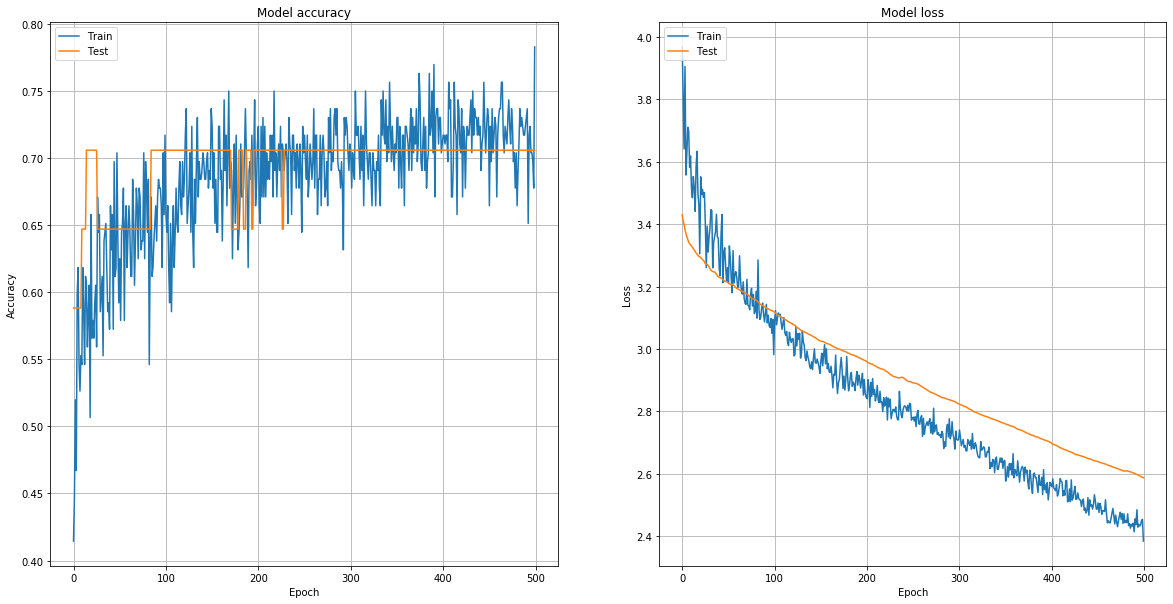

17/17 [==============================] - 0s 189us/step
Loss:2.588, Acc:0.7059


In [135]:
plot_history(history)
print("Loss:{:0.3f}, Acc:{:.4f}".format(*dnn.evaluate(X_valid,y_valid)))

Confusion matrix, without normalization
[[0.33333333 0.66666667]
 [0.09090909 0.90909091]]
Overall Accuracy: 0.7059


(<matplotlib.axes._subplots.AxesSubplot at 0x1a36070c18>, array([[ 2,  4],
        [ 1, 10]]))

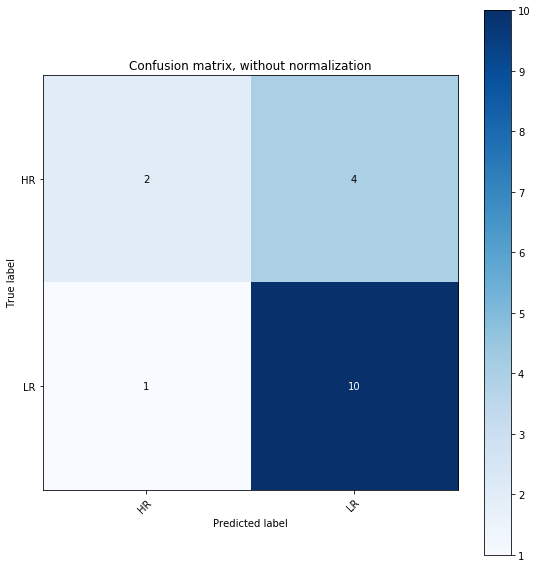

In [136]:
y_pred = np.round(np.ravel(dnn.predict(X_valid)))
plot_confusion_matrix(np.ravel(y_valid), y_pred, enc.categories_[1])

In [137]:
from sklearn.metrics import precision_score, make_scorer
prec_scorer = make_scorer(precision_score, pos_label=0)

precision_score(y_true=np.ravel(y_valid), y_pred=y_pred, pos_label=0)

0.6666666666666666

### Cross Validating

In [138]:
# Separating a hold out set that will be used for validation of the pipeline
# train_data, train_labels, test_data, test_labels = split_valid(data, risk_labels, valid_size=0.01)
train_data, train_labels, test_data, test_labels = data, risk_labels, [], []

In [139]:
risk_labels.value_counts()

1    114
0     55
dtype: int64

In [140]:
train_data.shape

(169, 83)

In [141]:
reducer = umap.UMAP(random_state=42,
                    n_components = 10,
                    n_neighbors=5,
                    min_dist=0)

In [142]:
dnn = build_dnn(num_features=data.shape[1], num_labels=1, activation="relu")
pipeline = ClusterPipeline(dnn, [train_data, train_labels], [test_data, test_labels],
                           target_class=0, reducer=reducer, softmax=False, analyzer_type="lrp.epsilon")

Running Serial Crossvalidation
Running worker: 0
Fold: 0 -> Loss:2.443, Acc:0.6373
Prediction Accuracy
18/18 [==============================] - 0s 3ms/step
Scores on data set: loss=2.427 accuracy=0.7778
Fold Correct: 14
Running worker: 1
Fold: 1 -> Loss:2.428, Acc:0.7402
Prediction Accuracy
18/18 [==============================] - 0s 42us/step
Scores on data set: loss=2.599 accuracy=0.3333
Fold Correct: 6
Running worker: 2
Fold: 2 -> Loss:2.464, Acc:0.6373
Prediction Accuracy
18/18 [==============================] - 0s 32us/step
Scores on data set: loss=2.471 accuracy=0.7778
Fold Correct: 14
Running worker: 3
Fold: 3 -> Loss:2.441, Acc:0.7304
Prediction Accuracy
18/18 [==============================] - 0s 31us/step
Scores on data set: loss=2.562 accuracy=0.4444
Fold Correct: 8
Running worker: 4
Fold: 4 -> Loss:2.376, Acc:0.7621
Prediction Accuracy
17/17 [==============================] - 0s 47us/step
Scores on data set: loss=2.597 accuracy=0.4118
Fold Correct: 7
Running worker: 5
Fold:

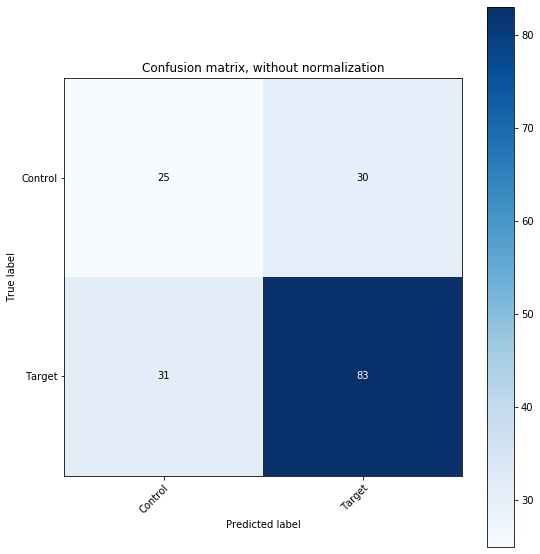

In [143]:
cm = pipeline.train_model(batch_size=int(10), epochs=400, smote=True,
                          cross_validation=True, parallel=False, verbose=0)

In [162]:
correct_ASD = cm[0][0]
print("Sensitivity: {:.4f}".format(correct_ASD/ np.sum(cm,axis=1)[0]))
print("PPV: {:.4f}".format(correct_ASD/ np.sum(cm,axis=0)[0]))

Sensitivity: 0.4545
PPV: 0.4464


In [ ]:
Sensitivity: 0.4000
PPV: 0.4783

In [150]:
from sklearn.preprocessing import MinMaxScaler
reducer = umap.UMAP(random_state=42,
                    n_components = 20,
                    n_neighbors=5,
                    min_dist=0)

pipeline.reducer_pipeline = Pipeline([
            ("umap", reducer),
            ("scaler",  MinMaxScaler())
        ])

_, correct_pred_idxs = pipeline.train_clusterer(plot=False, class_label = 0)
print("Clusters Found:", max(pipeline.clusterer.labels_)+1)

LRP Shape:  (25, 83)
Cluster Search Space: range(3, 8)
Minimum Size:
Clusters                  (4, 4)
Noise                     (3, 3)
Halkidi                   (3, 3)
Halkidi-Filtered Noise    (3, 3)
dtype: object
Clusters Found: 2


In [151]:
reindexed_labels = train_labels.iloc[pipeline.testing_idxs]
correct_idxs = pipeline.correct_preds_bool_arr
reindexed_labels.shape

(169,)

In [152]:
_correct=analysis_labels.loc[reindexed_labels[correct_idxs].index]
correct_HR = _correct[_correct["Risk"]=="HR"]
# enc.transform(correct_HR)[:,0]

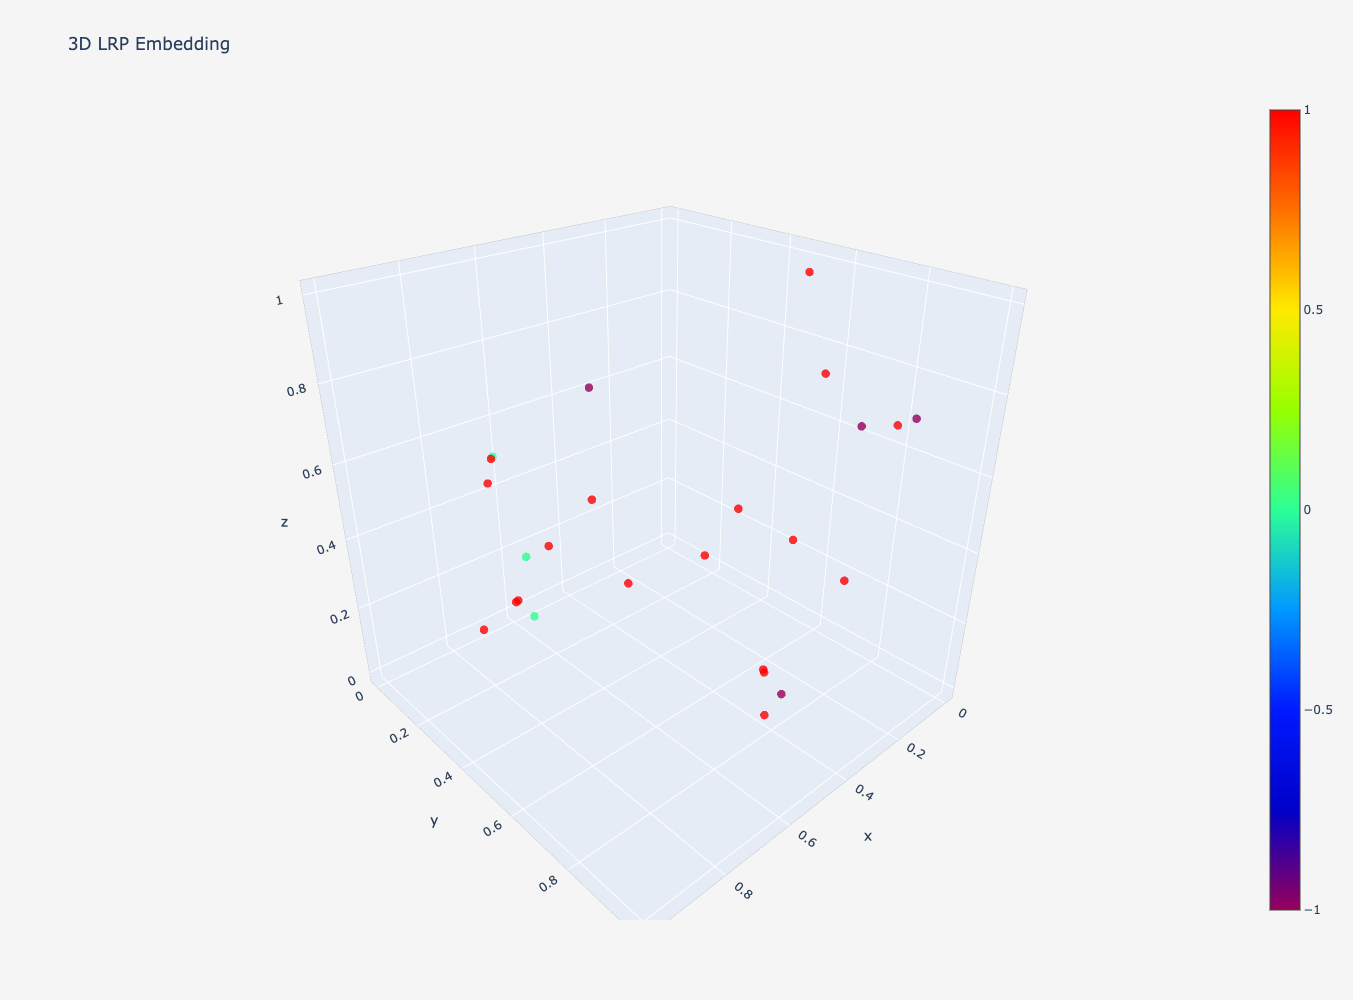

In [153]:
plot_3d_lrp(pipeline.training_lrp, colors=pipeline.clusterer.labels_, labels=correct_HR["ASD_DX_group"])

In [154]:
correct_HR["DNN Clusters"] = pipeline.clusterer.labels_
correct_HR

/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,ASD_DX_group,Risk,DNN Clusters
CandID,,,
172993,ASD,HR,1
336576,ASD,HR,1
417879,ASD,HR,1
638999,ASD,HR,0
552855,ASD,HR,-1
160209,ASD,HR,1
174982,ASD,HR,0
241033,ASD,HR,1
747349,ASD,HR,1


In [155]:
correct_HR.to_csv("csf_only_correct.csv")

In [30]:
orig_labels = analysis_labels.loc[reindexed_labels.index]
orig_labels["DNN Pred"] = pipeline.predictions
orig_HR = orig_labels[orig_labels["Risk"]=="HR"]

In [31]:
orig_HR.head()

,ASD_DX_group,Risk,DNN Pred
CandID,,,
172993,ASD,HR,0.0
336576,ASD,HR,0.0
417879,ASD,HR,0.0
597653,ASD,HR,0.0
638999,ASD,HR,0.0


In [32]:
_counts=[]
names=[]
for name, subgroup in orig_HR.groupby(by="ASD_DX_group"):
    names.append(name)
    _cnt = subgroup["DNN Pred"].value_counts()
    _counts.append([_cnt[0.0], _cnt[1.0]])
#     print(name, subgroup["DNN Pred"].value_counts(), sep="\n")

dnn_predictions = pd.DataFrame(_counts, columns=["Correct","Incorrect"], index=names)
dnn_predictions

,Correct,Incorrect
ASD,22,33


In [33]:
norm_pred = dnn_predictions.div(dnn_predictions.sum(axis=1), axis="index")

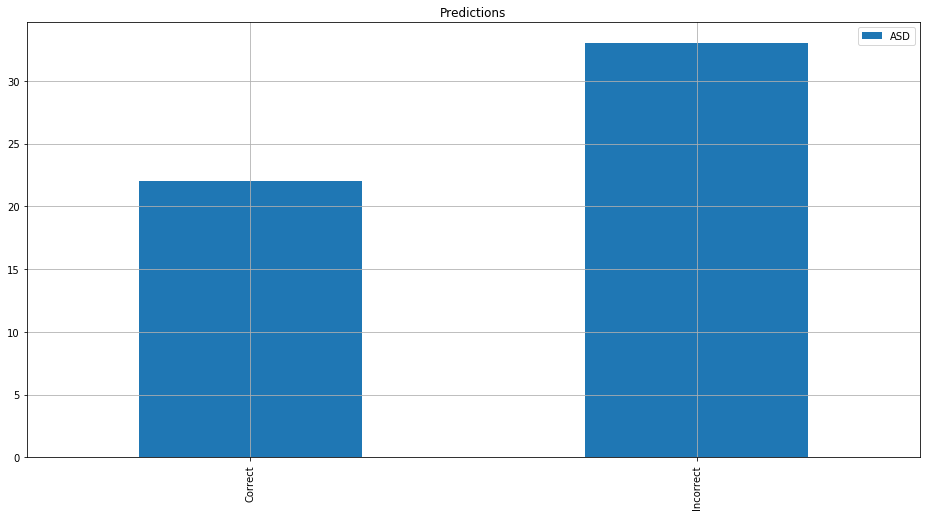

In [34]:
dnn_predictions.T.plot(kind="bar", figsize=(16,8), grid=True, title="Predictions")

In [ ]:
## 

# Performing Feature Reduction

In [49]:
def get_relevant_cols(df, thresh = 1e-2):

    all_above_thresh = (df < thresh).all(0) #Check if all values in columns satisfy the criteria
    max_above_thresh = (df.max() < thresh)
    quantile_above_thresh = (df.quantile(0.7) <= thresh) #IF most of the lrps are below thresh

    criteria = quantile_above_thresh
    irrelevant_cols = df.columns[criteria] 
    irrelevant_cols
    
    relevant_features_only = df.drop(columns = irrelevant_cols)
    
    return relevant_features_only

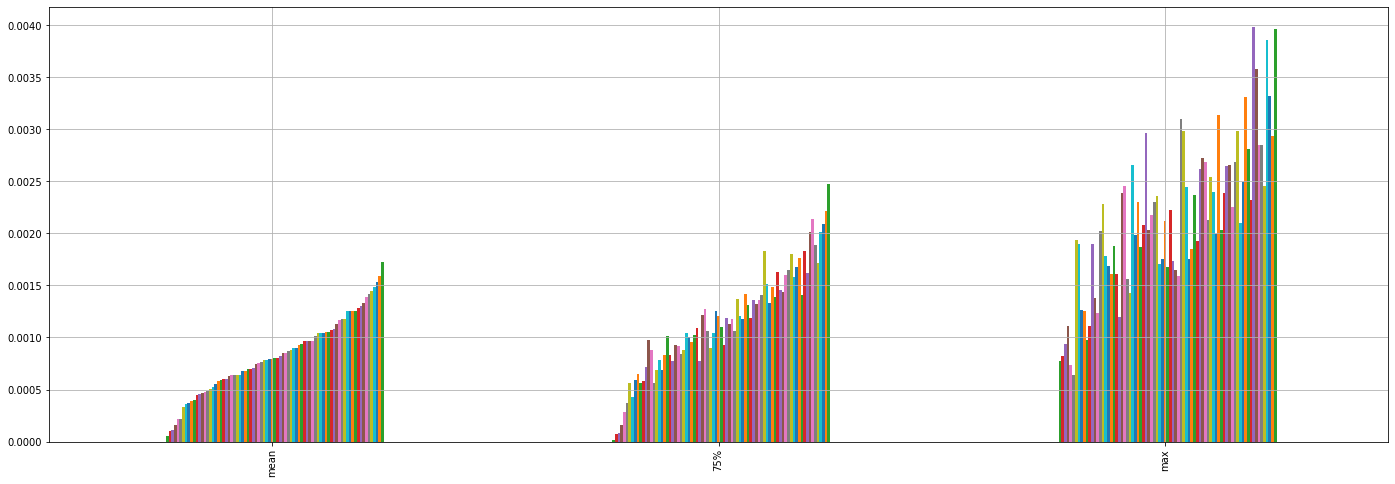

In [42]:
lrp_ = pd.DataFrame(pipeline.training_lrp)
metrics_ = lrp_.describe().loc[["mean","75%","max"]]

srtd_metrics = metrics_.sort_values(by=["mean"], axis=1)
srtd_metrics.plot(kind="bar", figsize=(24,8), legend=False, grid=True)

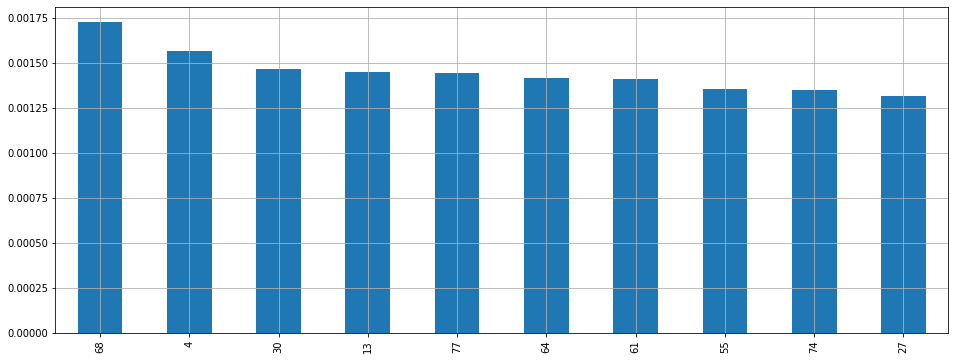

In [37]:
# Get top-K features for the given metric
K = 10
metric_fn = lambda x: x.quantile(0.5).sort_values(ascending=False)[:K]

lrp_metric = metric_fn(lrp_)
lrp_metric.plot(kind="bar", figsize=(16,6), legend=False, grid=True)

In [45]:
# metrics_.loc["mean"]

In [66]:
global_thresh = metrics_.loc["mean"].mean() + 3*metrics_.loc["mean"].std()
#     thresh = _clustered.quantile(0.8).quantile(0.5)
print("Thresh:", global_thresh)
reduced_cols = get_relevant_cols(lrp_, thresh=global_thresh).columns
print(reduced_cols, len(reduced_cols))

Thresh: 0.001976322047052846
Int64Index([4, 30, 56, 68], dtype='int64') 4


## Getting correctly predictied samples form target class

In [54]:
subcluster_labels = range(0,max(pipeline.clusterer.labels_)+1)

# Get testing samples from cross validation
reindexer = pipeline.testing_idxs

# That were correctly predicted
correct_preds = pipeline.correct_preds_bool_arr

# Separating Control from Target
target_samples  = train_labels.iloc[reindexer][correct_preds] == pipeline.target_class
control_samples = ~target_samples

target_class_features = train_data.iloc[reindexer][correct_preds][target_samples]
target_class_labels   = train_labels.iloc[reindexer][correct_preds][target_samples]
target_class_features.head()

,Hippocampus right,Hippocampus left,Amygdala right,Amygdala left,Anterior temporal lobe - medial right,Anterior temporal lobe - medial part left,Anterior temporal lobe - lateral right,Anterior temporal lobe - lateral left,Gyri parahippocampalis et ambiens right,Gyri parahippocampalis et ambiens left,...,Substantial nigra left,Substantial nigra right,Subgenual frontal cortex left,Subgenual frontal cortex right,Subcallosal area left,Subcallosal area right,Pre-subgenual frontal cortex left,Pre-subgenual frontal cortex left right,Superior temporal gyrus - anterior left,Superior temporal gyrus - anterior left right
CandID,,,,,,,,,,,,,,,,,,,,,
172993,235,62,124,72,1041,723,714,725,199,157,...,11,0,37,20,10,0,49,2,641,547
336576,127,73,66,22,984,1364,766,670,160,257,...,11,0,65,12,9,1,33,5,1238,1213
417879,139,114,35,49,1187,1734,661,672,172,241,...,7,0,84,31,36,3,53,5,1531,1196
597653,193,166,49,126,1207,712,635,489,212,229,...,4,1,35,32,14,4,56,2,744,814
638999,235,108,49,60,993,1179,877,719,162,198,...,18,1,98,27,28,4,70,10,1062,680


In [55]:
target_class_features.shape

(22, 83)

Cluster: 0
Size: 4
Cluster: 1
Size: 5
Cluster: 2
Size: 12


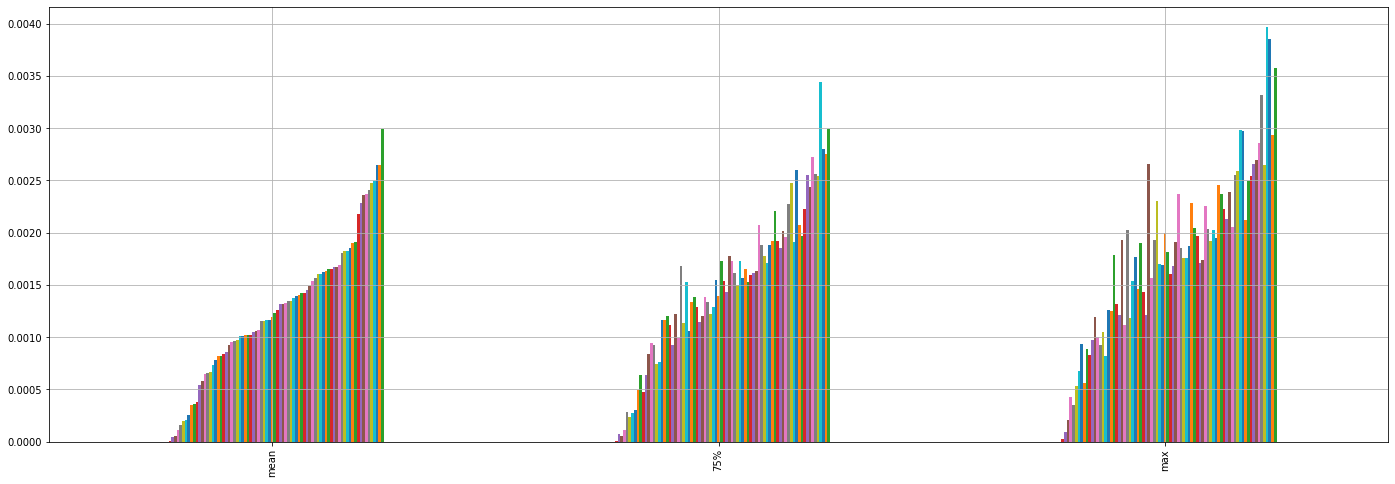

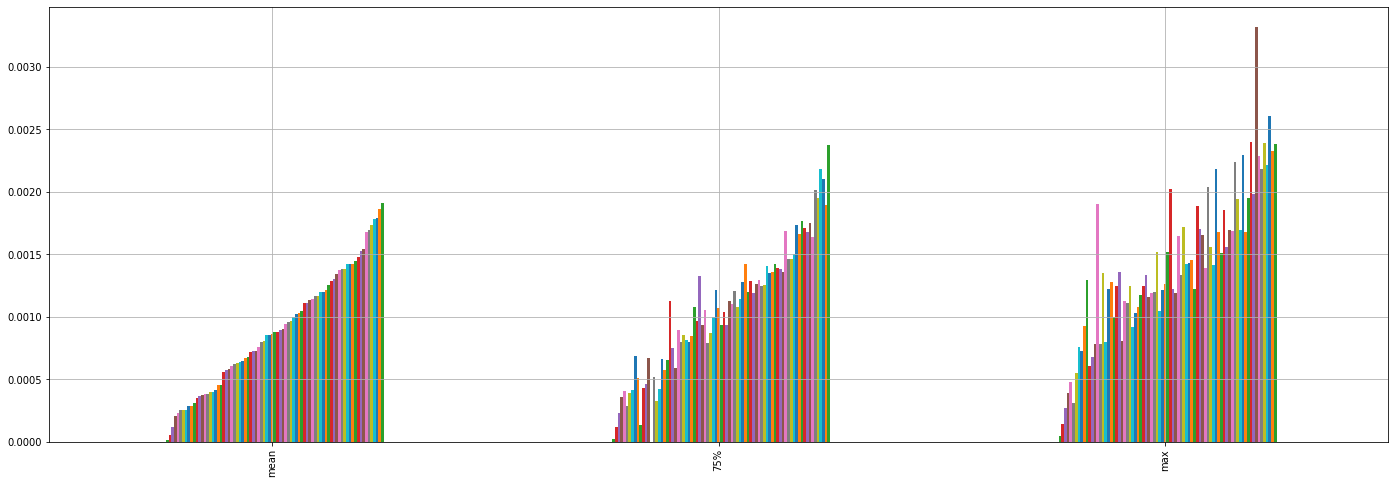

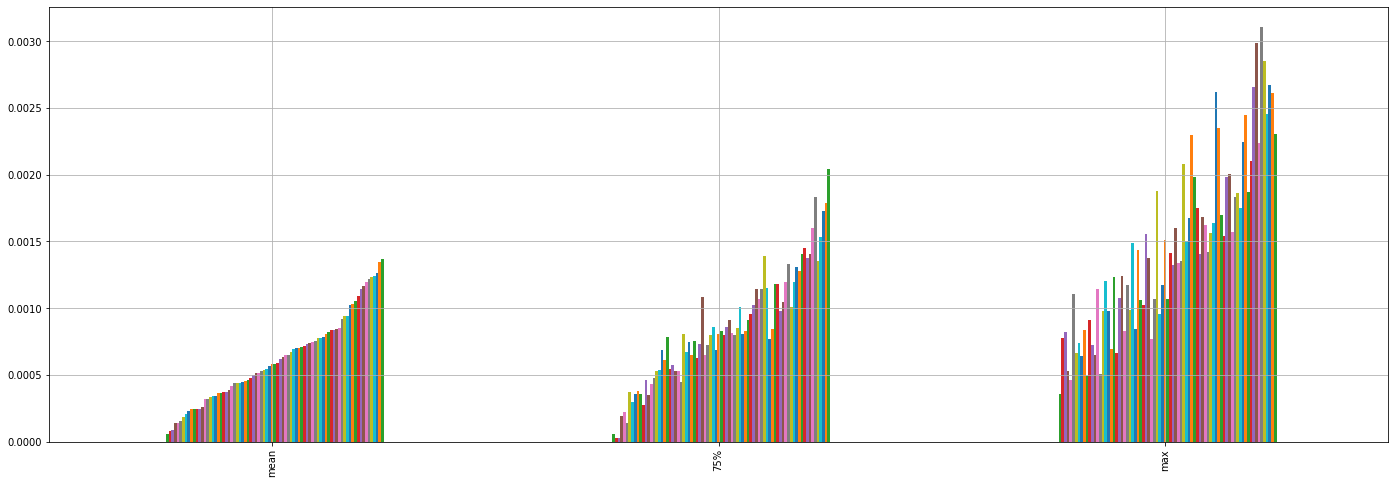

In [59]:
cluster_rels = {}
cluster_metrics = {}

for cluster_label in subcluster_labels:
    
    print("Cluster:", cluster_label)
#     tsamples = target_class_features[(pipeline.clusterer.labels_ == cluster_label)]
    tlabels  = target_class_labels[(pipeline.clusterer.labels_ == cluster_label)]
    print("Size:", tlabels.shape[0])
    
    _clustered = pd.DataFrame(pipeline.training_lrp[(pipeline.clusterer.labels_ == cluster_label)],
                              columns = train_data.columns)
#   
    _metrics = _clustered.describe().loc[["mean","75%","max"]]
    srtd_metrics = _metrics.sort_values(by=["mean", "75%", "max"], axis=1)
    srtd_metrics.plot(kind="bar", figsize=(24,8), legend=False, grid=True)
    
    cluster_metrics[cluster_label] = _metrics.T
    cluster_rels[cluster_label] = _clustered

## Individual metric histograms for each cluster

In [57]:
cluster_metrics[0]["mean"].std()

0.000705046666465234

Text(0.5, 0, 'Relevances')

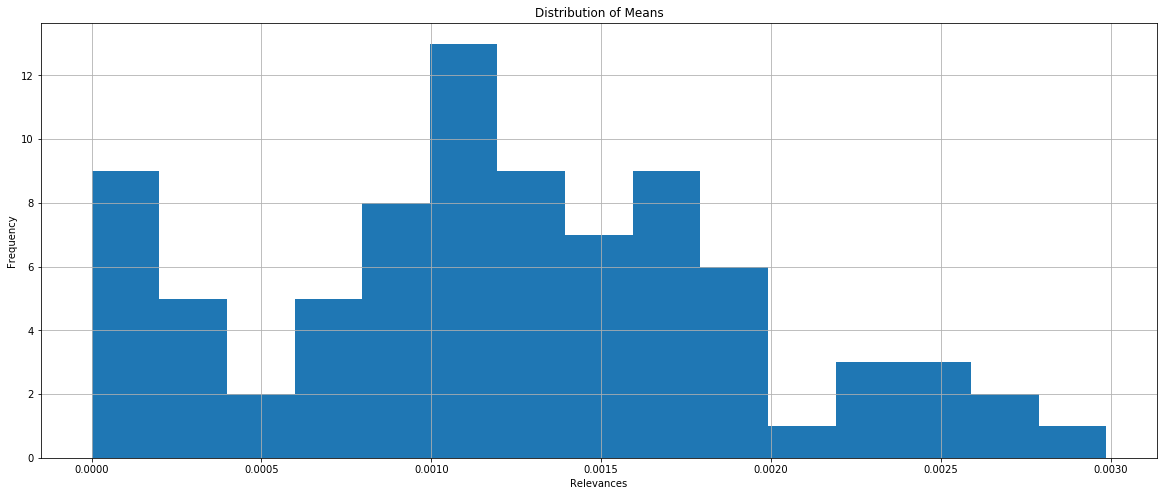

In [58]:
# Looks like (exponential) pareto...

ax = cluster_metrics[0]["mean"].plot(kind="hist", figsize=(20,8), bins=15, grid=True, title="Distribution of Means") 
ax.set_xlabel("Relevances")

Text(0.5, 0, 'Relevances')

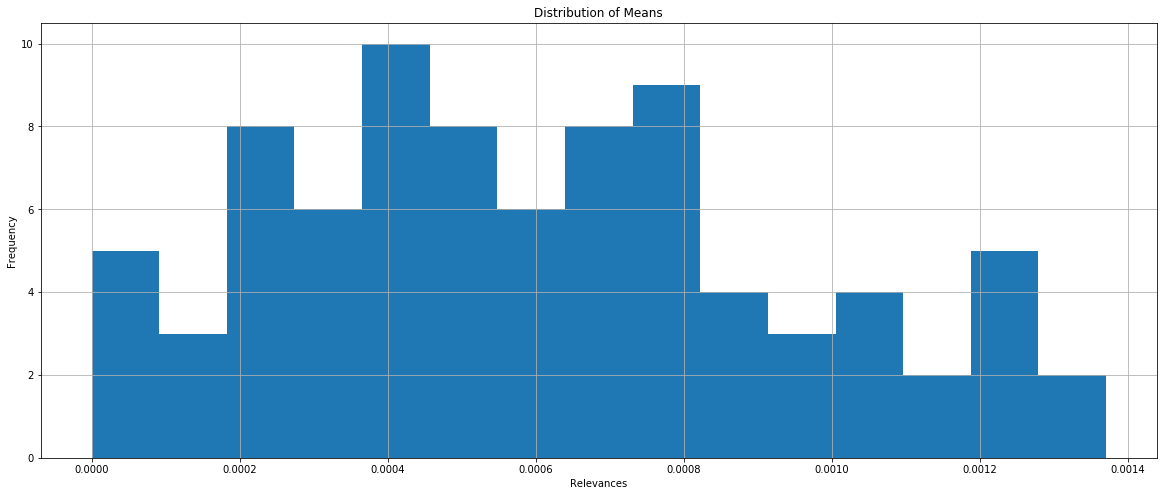

In [60]:
ax = cluster_metrics[2]["mean"].plot(kind="hist", figsize=(20,8), bins=15, grid=True, title="Distribution of Means") 
ax.set_xlabel("Relevances")

## Grabbing columns that were significantly more importnat than the global average LRP

In [65]:
for cluster_label in subcluster_labels:

#     thresh = cluster_metrics[cluster_label]["mean"].mean() + 2*cluster_metrics[0]["mean"].std()
# #     thresh = _clustered.quantile(0.8).quantile(0.5)
#     print("Thresh:", thresh)
    
    reduced_cols = get_relevant_cols(cluster_rels[cluster_label], thresh=global_thresh).columns
    print(reduced_cols, len(reduced_cols))

Index([' Amygdala left', 'Anterior temporal lobe - medial right',
       'Anterior temporal lobe - lateral right',
       'Gyri parahippocampalis et ambiens right',
       'Gyri parahippocampalis et ambiens left',
       'Lateral occipitotemporal gyrus fusiformis left', 'Cerebellum left',
       'Brainstem', 'Occipital lobe left', 'Occipital lobe right',
       'Cingulate gyrus - anterior right', 'Frontal lobe left',
       'Posterior temporal lobe right', 'Nucleus accumbens left',
       'Lateral ventricle frontal-central-occipital right',
       'Lateral ventricle frontal-central-occipital left',
       'Lateral ventricle temporal right', 'Third ventricle',
       'Precentral gyrus left', 'Straight gyrus rectus right',
       'Inferior frontal gyrus left', 'Inferior frontal right',
       'Superior parietal gyrus left', 'Lingual gyrus left',
       'Lingual gyrus right', 'Medial orbital gyrus left',
       'Medial orbital gyrus right', 'Lateral orbital gyrus left',
       'Lateral or